In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.datasets import fetch_openml

In [2]:
from sklearn.datasets import fetch_openml

eeg = fetch_openml(data_id=1471, as_frame=True)
# https://www.openml.org/d/1471
# the whole measurement spans 117 seconds

In [3]:
increment = 117 / len(eeg['data'])
fs = len(eeg['data']) // 117

In [4]:
len(eeg['data'])

14980

In [6]:
import numpy as np
index = np.linspace(
    start=0,
    stop=increment*len(eeg['data']),
    num=len(eeg['data'])
)

ts_index = pd.to_datetime(index, unit='s')
v1 = pd.Series(name='V1', data=eeg['data']['V1'].values, index=ts_index)

In [7]:
slicing = (v1.index >= '1970-01-01 00:00:08') & (v1.index <='1970-01-01 00:01:10.000000000')
v1[slicing]

1970-01-01 00:00:08.006208692    4289.74
1970-01-01 00:00:08.014019627    4284.10
1970-01-01 00:00:08.021830562    4280.00
1970-01-01 00:00:08.029641498    4289.74
1970-01-01 00:00:08.037452433    4298.46
                                  ...   
1970-01-01 00:01:09.962547566    4289.74
1970-01-01 00:01:09.970358501    4283.08
1970-01-01 00:01:09.978169437    4284.62
1970-01-01 00:01:09.985980372    4289.23
1970-01-01 00:01:09.993791307    4290.77
Name: V1, Length: 7937, dtype: float64

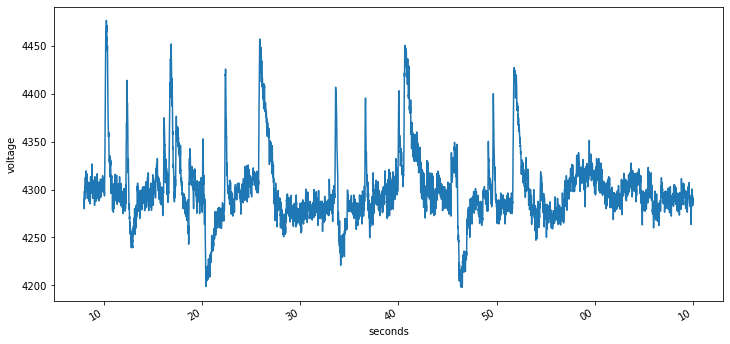

In [8]:
date_formatter = DateFormatter("%S")
ax = v1[slicing].plot(figsize=(12, 6))
ax.xaxis.set_major_formatter(date_formatter)
plt.ylabel('voltage')
plt.xlabel('seconds');

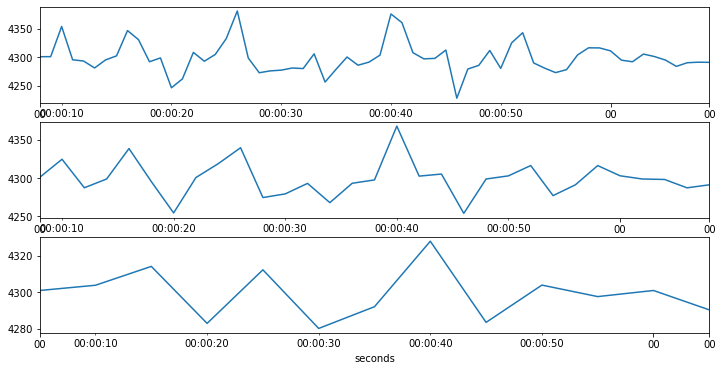

In [9]:
plt.subplot(311)
ax1 = v1[slicing].resample('1s').mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(312)
ax1 = v1[slicing].resample('2s').mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(313)
ax2 = v1[slicing].resample('5s').mean().plot(figsize=(12, 6))
ax2.xaxis.set_major_formatter(date_formatter)
plt.xlabel('seconds');

In [10]:
from scipy import signal
f, Pxx_den = signal.welch(
    v1[slicing].values,
    fs,
    nperseg=4000,
    scaling='spectrum'
)

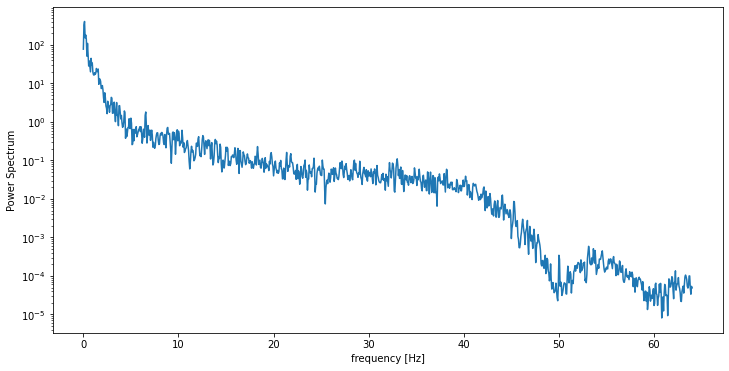

In [11]:
from scipy import signal
f, Pxx_den = signal.welch(
    v1[slicing].values,
    fs,
    nperseg=2048,
    scaling='spectrum'
)
plt.figure(figsize=(12, 6))
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectrum');

In [13]:
# https://datahub.io/core/global-temp

import pandas as pd
temperatures = pd.read_csv('monthly_csv.csv')
temperatures['Date'] = pd.to_datetime(temperatures['Date'])
temperatures = temperatures.pivot('Date', 'Source', 'Mean')

In [14]:
temperatures['GCAG'].index.month

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
             3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
           dtype='int64', name='Date', length=1644)

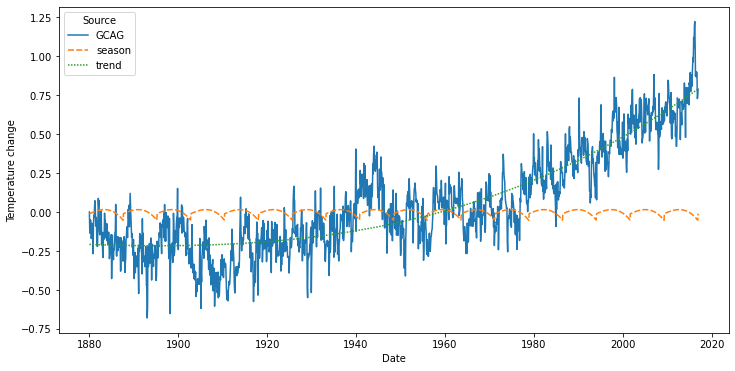

In [15]:
from numpy import polyfit

# fit polynomial: E = \sum_{j=0}^k |p(x_j) - y_j|^2

def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_season(s, yearly_periods=4, degree=3):
    X = [i%(365/4) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)

def get_trend(s, degree=3):
    X = list(range(len(s)))  # (s.index.year - s.index.year.min()).values
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)


import seaborn as sns

plt.figure(figsize=(12, 6))
temperatures['trend'] = get_trend(temperatures['GCAG'])
temperatures['season'] = get_season(temperatures['GCAG'] - temperatures['trend'])
sns.lineplot(data=temperatures[['GCAG', 'season', 'trend']])
plt.ylabel('Temperature change');

In [16]:
temperatures.head()

Source,GCAG,GISTEMP,trend,season
Date,,,,
1880-01-06,0.0009,-0.30,-0.207448,-0.010461
1880-02-06,-0.1229,-0.21,-0.207531,-0.009336
1880-03-06,-0.1357,-0.18,-0.207613,-0.008226
1880-04-06,-0.0499,-0.27,-0.207695,-0.007131
1880-05-06,-0.0738,-0.14,-0.207777,-0.006051
